In [1]:
import matplotlib
#matplotlib.use('Agg')
%matplotlib tk

%load_ext autoreload
%autoreload 2

#%matplotlib tk
%autosave 180

import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import os
from tqdm import tqdm

import scipy
import scipy.stats
from statsmodels.stats.multitest import multipletests

from sklearn.linear_model import LinearRegression
from scipy import stats
    

Autosaving every 180 seconds


<ipython-input-1-bb1f52018256>:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
     
def plot_longitudinal_svm_accuracy_concatenated_sessions_lockouts(root_dir,
                                                                  animal_ids, 
                                                                  lockout):
    #
    fig = plt.subplots(figsize=(10,8))
    #animal_ids = ["M1", "M2", "M3", "M4","M5",'M6']

    #
    smooth = True
    smooth_window = 30
    significance = 0.05
    #auc = []
    #early = []
    #from tqdm import tqdm, trange
    for k, animal_id in enumerate(animal_ids):
        # fnames = np.loadtxt(os.path.join(root_dir,name,
        #                                  'concatenated_svm.txt'),dtype='str')

        ax=plt.subplot(2,3,k+1)

        #
        fname_accs = os.path.join(root_dir,animal_id+
                                         'acc_all_sessions_smooth_lockout_'+str(lockout)+'.npy')
        fname_edts = os.path.join(root_dir,animal_id+
                                         'edts_all_sessions_smooth_lockout_'+str(lockout)+'.npy')
        fname_aucs = os.path.join(root_dir,animal_id+
                                         'aucs_all_sessions_smooth_lockout_'+str(lockout)+'.npy')
        
        # 
        acc_array = []
        edts_array = []
        auc_array = []
        if os.path.exists(fname_accs):
            acc_array = np.load(fname_accs)
            colors = plt.cm.viridis(np.linspace(0,1,len(acc_array)))
            #print ('fname_accs: ', fname_accs)

             ##############################
            #
            for ctr,acc in enumerate(acc_array):
                mean = acc.mean(1)
                t = np.arange(mean.shape[0])/30-28
                ax.plot(t,mean,
                        linewidth=5,
                        color=colors[ctr])

        else:
            fnames = []
            for k in range(0,5000,50):
                fname = os.path.join(root_dir,
                                     animal_id,
                                    'super_sessions',
                                   'alldata_body_and_nonreward_lockout_'+str(lockout)+'secLockout_[]bodyfeats_'+str(k)+'_super_res.npz')
                if os.path.exists(fname):
                    fnames.append(fname)
                else:
                    break
            
            #print ("fnames: ", fnames)
            
            # 
            colors = plt.cm.viridis(np.linspace(0,1,len(fnames)))

            for ctr,fname in tqdm(enumerate(fnames)):

                #
                data = np.load(fname, allow_pickle=True)
                acc = data['accuracy'][:870]  # use data from -30sec to 0
                #print ("acc: ", acc.shape)
                predictions = data['predictions']
                if predictions.shape[1]<100:
                    continue

                #print ('acc: ', acc.shape)
                if smooth:
                    data = []
                    for p in range(acc.shape[1]):
                        box = np.ones(smooth_window)/smooth_window

                        trace_smooth = np.convolve(acc[:,p],
                                                   box,
                                                   mode='valid')

                        data.append(trace_smooth)
                    data = np.array(data)
                    acc = np.array(data).copy().T

                acc_array.append(acc)

                ##############################
                #
                mean = acc.mean(1)
                t = np.arange(mean.shape[0])/30-28
                #print ("t.shape,", t.shape, 't: ', t[:10])
                ax.plot(t,mean,
                        linewidth=2,
                        color=colors[ctr])

                # append area under cruve up to t = -10sec
                #print ("mean data: ", mean.shape)
                
                temp = mean[-300:]  # last 10sec prior to movement
                auc_array.append(temp.sum())

                sig, earliest = compute_significance3(data.T,
                                                      significance)
                edts_array.append(earliest)


            np.save(fname_accs, acc_array)
            np.save(fname_edts, edts_array)
            np.save(fname_aucs, auc_array)

        plt.ylim(0.4,1.0)
        plt.xlim(-15,0)
        plt.plot([-30,0],[0.5,0.5],'--',c='black')

        #
        plt.xlabel("Time (sec)")
        plt.ylabel("SVM accuracy")
       # plt.title(animal_ids[k])
    
    
def compute_significance3(data,
                          significance):

    #print ("self.data: ", data.shape)

    mean = data.mean(1)
    #
    sig = []
    for k in range(data.shape[0]):

        #
        res = scipy.stats.ttest_1samp(data[k], 0.5)

        sig.append(res[1])

    #
    sig_save = np.array(sig).copy()

    # multiple hypothesis test
    temp = np.array(sig)
    temp2 = multipletests(temp, alpha=significance, method='fdr_bh')
    sig = temp2[1]
    
    ##fig=plt.figure()
   # print ('sig: ', sig.shape)
    #plt.plot(sig)

        
    #
    sig=np.array(sig)[None]

    
    
    ## any values over 
    #thresh = significance
    #idx = np.where(sig>thresh)
    #sig[idx] = np.nan

    # check this to ensure not going below chance
    idx = np.where(mean<0.5)
    sig[:,idx] = np.nan
    #print ("SIG: ", sig.shape)

    # find earliest
    earliest_continuous = sig.shape[1]
    for k in range(sig.shape[1]-1,0,-1):
        if sig[0][k]<=significance:
            earliest_continuous = k
        else:
            break

    earliest_continuous = -(sig.shape[1]-earliest_continuous)/30.
    #print ('earliest cont: ', earliest_continuous)
    return sig, earliest_continuous

#       
def plot_edts_longitudinal(root_dir, 
                           animal_ids, 
                           lockout,
                           smoothing_flag):

    colors = ['black','blue','red','green','magenta','pink','cyan']
    fig=plt.figure(figsize=(6,6))
    names_biorxiv = ["M1", "M2", "M3", "M4","M5",'M6']

    #
    for k in range(len(animal_ids)):

        ax=plt.subplot(3,2,k+1)

        if smoothing_flag==False:
            fname = os.path.join(root_dir,animal_ids[k]+
                                             'edts_all_sessions_smooth_lockout_'+str(lockout)+'.npy')

            edts = np.load(fname)
        else:
            fname = os.path.join(root_dir,
                                 animal_ids[k]+
                                 '_edts_locked_out_filtered_'+str(lockout)+'.npz')
            data = np.load(fname)
            edts = data['all_res_continuous']
        
        
        #temp = np.array(early[k])
        temp = edts

        #
        #idx =np.where(temp<-20)[0]  #j
        #temp[idx]=temp[idx-1]
        t = np.arange(temp.shape[0])/temp.shape[0]

        #
        lr = LinearRegression()
        lr.fit(t.reshape(-1, 1), temp.reshape(-1, 1))

        #
        temp2 = np.poly1d(np.polyfit(t, temp, 1))(t)
        plt.plot(t, temp2,
                 linewidth=6,
                 #label=ids[k]+ " ***** ",
                 c='black')

        #
        corr = scipy.stats.pearsonr(t,temp)
        print ("corrL: ", corr)

        plt.scatter(t,
                    temp,
                    #label=names[k]+ " "+str(round(corr[0],2))+
                    #                        " ("+str("pval: {0:.1}".format(corr[1]))+")",
                    s=200,
                    #linewidth=4,
                    c='grey',
                    alpha=.8,
                    label = "pcor: "+ str(np.round(corr[0],4))+ "\n pval " + str(np.round(corr[1],4)))
        #t = np.arange(auc1.shape[0])/(auc1.shape[0]-1)

        plt.xticks([])
        #plt.yticks([])
        legend = plt.legend(handlelength=0, fontsize=10)

        #plt.legend(fontsize=12)
        plt.ylim(-12,0)
        plt.xlim(t[0],t[-1])
        plt.title(names_biorxiv[k])


In [3]:
###############################################################
########################## Fig 4b #############################
###############################################################

# Fig 4b from paper longitudinal viridis plots
root_dir = '/media/cat/4TBSSD/yuki/'
animal_ids = ['IA1','IA2','IA3','IJ1','IJ2','AQ2']
lockout = 15

#animal_ids = ['IA1']
# 
plot_longitudinal_svm_accuracy_concatenated_sessions_lockouts(root_dir,
                                                               animal_ids,
                                                               lockout)


# 
plt.show()
#plt.savefig('/home/cat/edts_longitudinal_acc_lockout.svg')
#plt.close()
#visualize.plot_longitudinal_svm_accuracy_concatenated_sessions_lockouts()

In [6]:
#########################################
############### Fig 4c ##################
#########################################

# Fig 4c - note slighly different corr vals obtained from single sessions compared to biorxiv which used concatenated sessionss
animal_ids = ['IA1','IA2','IA3','IJ1','IJ2','AQ2']  
lockout = 12

# 
smoothing_flag = True
plot_edts_longitudinal(root_dir, 
                       animal_ids,
                       lockout,
                       smoothing_flag) 
plt.show()
#plt.savefig('/home/cat/edts_longitudinal_lockout_smoothing'+str(smoothing_flag)+'_lockout'+str(lockout)+'.svg')
#plt.close()

corrL:  (0.7323179806109831, 0.006762404179800621)
corrL:  (-0.000367216182011354, 0.9990059345432017)
corrL:  (-0.6601384816619972, 0.15363078041168005)
corrL:  (-0.5038014397263025, 0.24899426925188398)
corrL:  (0.8937125067539528, 0.10628749324604725)
corrL:  (0.07777246026548779, 0.7590435015098689)


In [19]:
#########################################
############### Fig 4d,e ################
#########################################
 
# Fig 4d or e; convex hull plots of 1sec temporal windows
root_dir = './data/'
animal_id = 'IA1'

#session = 'IJ2pm_Mar31_30Hz'
session = 'IA1pm_Feb9_30Hz'

#
Visualize.plot_convex_hulls_10sec(root_dir, animal_id, session)

# d = np.load('/home/cat/code/widefield/elife_paper_code/data/IA1/tif_files/IA1pm_Feb9_30Hz/pa_all_points_full.npy')
# print (d.shape)

# np.save('/home/cat/code/widefield/elife_paper_code/data/IA1/tif_files/IA1pm_Feb9_30Hz/pa_all_points.npy',
#        d[:,:,:20])

NameError: name 'Visualize' is not defined

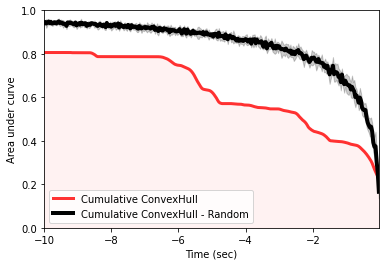

In [34]:
#####################################################
#################### Fig 4f #########################
#####################################################

# Fig 4f - area under curve vs. random 1sec segments
root_dir = './data/'
animal_id = 'IA1'

#session = 'IJ2pm_Mar31_30Hz'
session = 'IA1pm_Feb9_30Hz'

#
Visualize.plot_area_under_curve_1sec_segments(root_dir,
                                       animal_id,
                                       session)

In [32]:
data = np.load('/media/cat/4TBSSD/yuki/IA1/super_sessions/alldata_body_and_nonreward_lockout_15secLockout_[]bodyfeats_0.3hz_0_super_res.npz',
               allow_pickle=True)

pred = data['predictions']
print (pred.shape)

(1770, 400)
